# Numpy-style Reimplementation of `Trans_GreenFunction`
As a result of the comparison, the numpy indexing version is identical to the for-loop version. The for-loop version can be accessed via the `mode='legacy'` parameter.
Using the script with the same name as the current notebook, it was verified that the numpy-style version requires about 35% less computation time.

In [27]:
import logging

log_format = "%(asctime)s [%(threadName)-10.10s] [%(name)-14.14s] [%(levelname)-5.5s]  %(message)s"
logging.basicConfig( #filename='{:%Y-%m-%dT%H%M%S}.log'.format(datetime.now()),
                    level=logging.INFO,
                    format=log_format,)

# child logger for local use
logger = logging.getLogger(__name__ + '.nb')
logger.setLevel(logging.DEBUG)

def printl(*args, sep=' '):
    logging.info(sep.join([str(val) for val in args]) )

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:

sys.path.append('../') 

In [7]:
from DWFA_cyl_func_Ng import FindMode, Long_GreenFunction, Trans_GreenFunction, WakePotential, BunchDistG, BunchDistrib, BunchDistU, multimode_trans_greens_function


In [8]:
a = 0.69e-3
b = 1.29e-3
eps_r = 9.6
l_dlw = 0.09


m_range = (1,8)
n_max = 8
# large_al2o3_streaker.find_modes((1,8), 10)
# N_z_wake = 1001

In [9]:

from scipy.special import jnp_zeros
u_11 = jnp_zeros(1,1)[0]
assert m_range[1] > m_range[0] and len(m_range) == 2

m_range = tuple(m_range)
num_m = m_range[1] - m_range[0]
num_n = n_max

mode_ampl = np.empty((num_m, num_n))
mode_wave_vec = np.empty((num_m, num_n))

for m in range(*m_range):
    logger.info(f"Computing {n_max} amplitudes and wavevectors for angular mode number m={m}...")
    mode_ampl[m - m_range[0]], mode_wave_vec[m - m_range[0]] =\
        FindMode(b, a, n=m, epsilon=eps_r, Nmode = n_max, num_k_sampling = 500) 
        ## Old version
        # FindMode(outer_radius, inner_radius, n=m, epsilon=eps_r, Nmode=n_max, 
        #          k_0= u_11/(2*np.pi*outer_radius))

max_wvl = 2*np.pi/np.min(mode_wave_vec)
logger.debug(f"Max. wavelength: {max_wvl:1.2e} m")

2024-07-09 22:44:18,006 [MainThread] [__main__.nb   ] [INFO ]  Computing 8 amplitudes and wavevectors for angular mode number m=1...
2024-07-09 22:44:18,041 [MainThread] [DWFA_cyl_func_] [INFO ]  
    ----- Summary ------
    mode order =1
    Roots:[ 2336.130675    3717.16629328  7384.86699626  8375.70412892
 12371.58365912 13423.4140709  17383.83530015 18569.75782818]
    dDisp:[ 0.83437312 -0.43829695  0.13101157 -0.11469033  0.08116283 -0.0752412
  0.06700684 -0.06344291]
    Mode Amplitudes:[1.54766728e+17 1.27713745e+18 9.46421041e+17 1.20233750e+18
 1.34658268e+18 7.49116520e+17 1.39677066e+18 4.73214599e+17]
    Mode WaveVectors / m^-1 :[ 796.61394831 1267.54318544 2518.2187446  2856.0914025  4218.6750129
 4577.34620636 5927.83863649 6332.23486208]
    Mode Wavelengths /m :[0.00788737 0.00495698 0.00249509 0.00219992 0.00148937 0.00137267
 0.00105995 0.00099225]
    --------------------
2024-07-09 22:44:18,041 [MainThread] [__main__.nb   ] [INFO ]  Computing 8 amplitudes and wa

In [10]:
r_offset = 0.45e-3
N_z = 1001

kwargs= {
        "r0" : r_offset, "r": r_offset, 
        "b": a, "a" : b,
        "zmin": 0, "zmax" : max_wvl,
        "Nz": N_z , "epsilon": eps_r
    }
m = 1
# for m in range(*m_range):
kwargs["RootAmplit"] = mode_ampl[m - m_range[0]]
kwargs["RootWavVec"] = mode_wave_vec[m - m_range[0]]
kwargs["n"] = m
z, w_t = Trans_GreenFunction(**kwargs)

In [11]:
%%timeit -r 10 -n 10
z, w_t = Trans_GreenFunction(**kwargs)

195 µs ± 104 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


Text(0, 0.5, 'wake potential function / V/C')

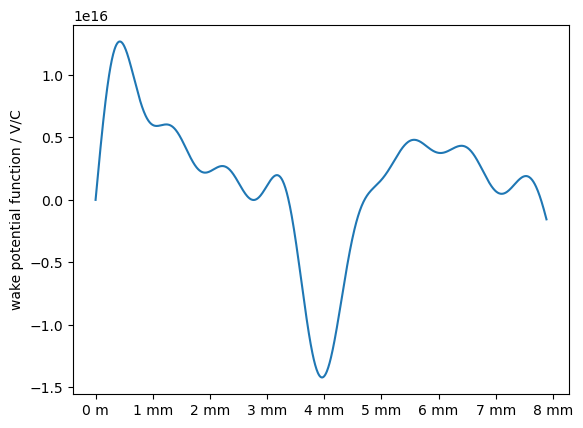

In [12]:
fig, ax = plt.subplots()
ax.plot(z, w_t)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='m'))
ax.set_ylabel('wake potential function / V/C')

In [13]:
kwargs["RootAmplit"]

array([1.54766728e+17, 1.27713745e+18, 9.46421041e+17, 1.20233750e+18,
       1.34658268e+18, 7.49116520e+17, 1.39677066e+18, 4.73214599e+17])

In [14]:
from scipy.constants import e as qelec, epsilon_0
import math

In [15]:
zz=np.linspace(kwargs['zmin'], kwargs['zmax'], kwargs['Nz'])
n=m

WakeGreen=0.0*zz
Nmode=len(kwargs["RootAmplit"])
F_=np.zeros(Nmode)
NormalizationCGS2SI=qelec*qelec/(b*b)*  (r_offset/b)**n  *(r_offset/b)**(n-1)  *8.0*n*np.sqrt(eps_r-1.0)/(a/b)**(2.0*n) /(4*math.pi*epsilon_0)


In [19]:
# %%timeit -r 10 -n 10
WakeGreen = np.sum((kwargs["RootAmplit"]/(kwargs["RootWavVec"]*np.sqrt(eps_r * 1 - 1.0)*b))[:, np.newaxis] * np.sin(np.outer(kwargs["RootWavVec"], zz)), axis=0)
WakeGreen *= NormalizationCGS2SI/qelec

Text(0, 0.5, 'wake potential function / V/C')

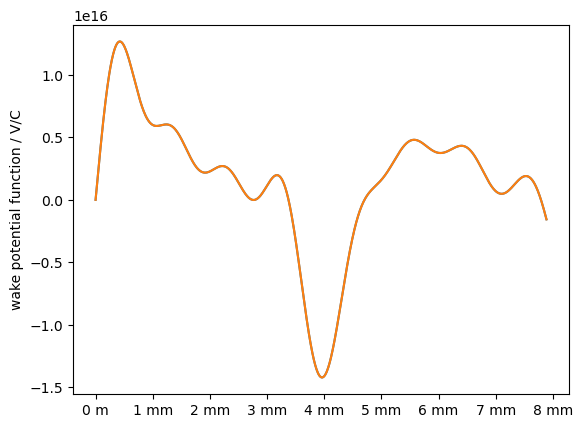

In [25]:
fig, ax = plt.subplots()
ax.plot(zz, WakeGreen)
ax.plot(z, w_t)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='m'))
ax.set_ylabel('wake potential function / V/C')

In [26]:
np.all(np.isclose(w_t, WakeGreen))

True